In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            
#             print(directory + '/' + filename)
            
            image = cv2.imread(directory + '/' + filename)
            
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            # image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])            
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    print(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [4]:
augmented_path = '/content/drive/My Drive/breast_cancer_full/augmented_data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'


print(augmented_yes)
print(augmented_no)
# print(augmented_normal)

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

/content/drive/My Drive/breast_cancer_full/augmented_data/yes
/content/drive/My Drive/breast_cancer_full/augmented_data/no
[[1]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]
Number of examples is: 1560
X shape is: (1560, 240, 240, 3)
y shape is: (1560, 1)


In [5]:
# print(X)
print(y)

[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [0]]


In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Breast_cancer: {label_to_str(label)}")
        plt.show()

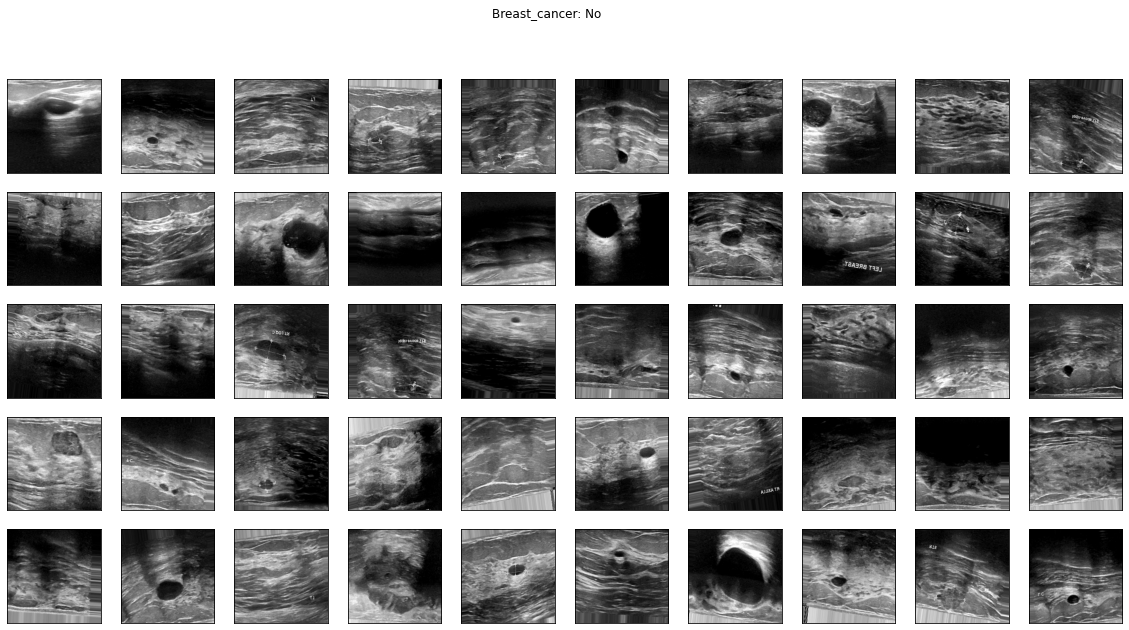

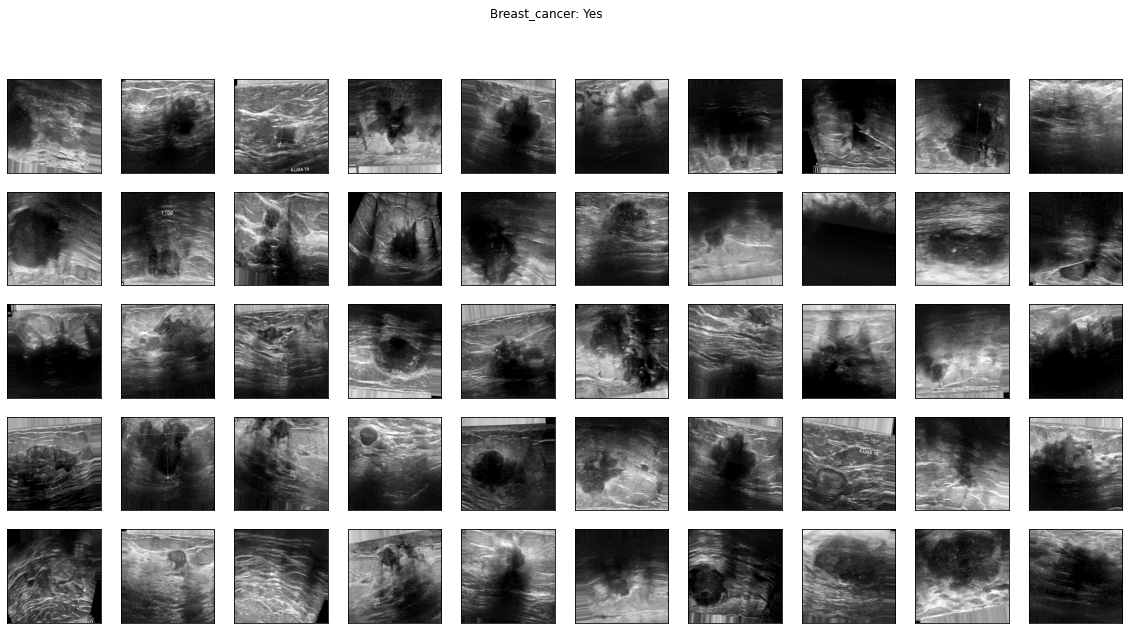

In [7]:
plot_sample_images(X, y)

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1092
number of development examples = 234
number of test examples = 234
X_train shape: (1092, 240, 240, 3)
Y_train shape: (1092, 1)
X_val (dev) shape: (234, 240, 240, 3)
Y_val (dev) shape: (234, 1)
X_test shape: (234, 240, 240, 3)
Y_test shape: (234, 1)


In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='Breast_cancer_DetectionModel')
    
    return model

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "Breast_cancer_DetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'breast_cancer_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'/content/drive/My Drive/Breast/logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("/content/drive/My Drive/Breast/models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/50
35/35 [==============================] - 35s 96ms/step - loss: 0.7154 - accuracy: 0.6978 - val_loss: 0.7934 - val_accuracy: 0.7436
INFO:tensorflow:Assets written to: /content/drive/My Drive/Breast/models/cnn-parameters-improvement-01-0.74.model/assets
Epoch 2/50
35/35 [==============================] - 2s 53ms/step - loss: 0.5282 - accuracy: 0.7546 - val_loss: 1.0864 - val_accuracy: 0.7137
INFO:tensorflow:Assets written to: /content/drive/My Drive/Breast/models/cnn-parameters-improvement-02-0.71.model/assets
Epoch 3/50
35/35 [==============================] - 2s 52ms/step - loss: 0.5138 - accuracy: 0.7756 - val_loss: 0.6428 - val_accuracy: 0.6581
INFO:tensorflow:Assets written to: /content/drive/My Drive/Breast/models/cnn-parameters-improvement-03-0.66.model/assets
Epoch 4/50
35/35 [==============================] - 2s 52ms/step - loss: 0.4905 - accuracy: 0.7766 - val_loss: 0.6404 - val_accuracy: 0.6325
INFO:tensorflow:Assets written to: /content/drive/My Drive/Breast/models

In [21]:
X_test.shape

(234, 240, 240, 3)

In [28]:
def load_data1(file_path,image_size):
    
    X2 = []
    
    image_width, image_height = image_size
    print(file_path)
    image = cv2.imread(file_path)
    # crop the brain and ignore the unnecessary rest part of the image
    # image = crop_brain_contour(image, plot=False)
    # resize image
    image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
    # normalize values
    # image = image / 255.
    # convert image to numpy array and append it to X
    X2.append(image)
    
    X2 = np.array(X2)
    
    print(f'Number of examples is: {len(X2)}')
    print(f'X shape is: {X2.shape}')
    
    return X2

In [32]:
file_path="/content/drive/MyDrive/breast_cancer_full/malignant/malignant (9).png"
img=load_data1(file_path,(IMG_WIDTH, IMG_HEIGHT))

/content/drive/MyDrive/breast_cancer_full/malignant/malignant (9).png
Number of examples is: 1
X shape is: (1, 240, 240, 3)


In [31]:
best_model = load_model(filepath='/content/drive/My Drive/Breast/models/cnn-parameters-improvement-49-0.80.model')

ss=best_model.predict(img)

print(ss)

if ss[0][0]>0.2:
    output="malignant"
else:
    output="benign"
        
print(output)

[[0.46188208]]
malignant
